# Redes Neuronales Convolucionales

En esta práctica vamos a construir y entrenar una red neuronal convolucional para un conjunto de datos extraídos de las reseñas de películas publicadas en la famosa web [IMBD](https://www.imdb.com/). El objetivo de esta red neuronal es deducir si las reseñas sobre estas películas son positivas (etiquetado como 1) o negativas (etiquetado como 0).

La parte inicial es análoga a la de la práctica anterior.

## Carga de la información
Empezamos importando los módulos que vamos a utilizar:

In [23]:
import numpy as np
from tensorflow.keras.datasets import imdb

Aunque la información viene ya informada como un vector numérico vamos a convertirla en texto para estudiar el caso desde el origen. Comenzamos cargando los datos:

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

Observamos que los datos vienen separados en datos de entrenamiento (`train`) y datos de validación (`test`). Además se cargan por separado las variables predictoras (`X`) y la variable objetivo (`y`).

Podemos observar que la información viene en vectores numéricos:

In [24]:
x_train[0][0:24]

array([ 132,   44,   22, 1408,   30,    3,   19,    9,  212,   25,   74,
         49,    2,   11,  404,   13,   79,    5,    1,  104,  114, 5924,
         12,  253], dtype=int32)

Transformamos estos vectores en el texto original:

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
x_train_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in sequence]) for sequence in x_train]
x_test_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in sequence]) for sequence in x_test]

__Nota.__ Cuando cargamos los datos IMDB utilizando esta función, las palabras están indexadas desde el número 3 en adelante, en lugar de 0 por eso el -3 en la función `get`.

In [25]:
x_train_text[0].split()[0:24]

['?',
 'this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being']

Esta reseña es claramente positiva. Vamos a comprobar que la etiqueta es 1:

In [26]:
y_train[0]

1

## Preprocesamiento de la información

Vamos a empezar por tokenizar los textos. Para ello definimos el tamaño máximo del vocabulario que vamos a permitir, es decir, cuántas palabras distintas le vamos a enseñar. En este caso marcaremos 7500 pero os animo a probar otros valores y ver cómo esto afecta a los resultados:

In [ ]:
tamano_vocabulario = 7500
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizador = Tokenizer(num_words=tamano_vocabulario) #creamos el tokenizador
tokenizador.fit_on_texts(x_train_text) # lo entrenamos sobre nuestros textos de entrenamiento

Una vez entrenado lo aplicamos sobre nuestros textos de entrenamiento y validación:

In [ ]:
x_train_seq = tokenizador.texts_to_sequences(x_train_text)
x_test_seq = tokenizador.texts_to_sequences(x_test_text)

In [ ]:
x_train_seq[0][0:24]

Ya tenemos nuestro vector numérico. Debido a que vamos a trabajar con redes neuronales necesitamos que todas las secuencias tengan el mismo tamaño, es decir, el mismo número de palabras. Para ello lo que vamos a hacer es fijar ese máximo de palabras en, por ejemplo, 100 y; o bien cortar las secuencias que tengan más de 100 palabras, o bien rellenar las que tienen menos de 100 para que tengan 100. De esta manera conseguimos que todas las secuencias tengan el mismo tamaño. Este proceso suele denominarse `padding`. De nuevo os animo a probar otros valores de este mismo parámetro:

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
longitud_maxima = 100
x_train = pad_sequences(x_train_seq, maxlen=longitud_maxima)
x_test = pad_sequences(x_test_seq, maxlen=longitud_maxima)

Ya estamos listos para construir nuestra red neuronal. Para ello vamos a utilizar Keras:

## Construcción de la red

Vamos a proceder a construir la red capa por capa ayudándonos de Keras:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

Comienzo indicando que la red va a construirse de manera secuencia, es decir, que vamos a ir añadiendo una capa delante de otra:

In [ ]:
red = Sequential()

Añadimos en primer lugar una capa de embedding que transformará los números enteros que representan las palabras en vectores de la dimensión indicada, en este caso, 128:

In [ ]:
red.add(Embedding(tamano_vocabulario, 128))

A continuación añadimos una capa de convoluciones unidimensionales. Esta capa aplica 64 filtros convolucionales de tamaño 5 a las secuencias. Además usamos la función de activación `relu` que permite al modelo aprender representaciones no lineales de los datos:

In [ ]:
red.add(Conv1D(64, 5, activation='relu'))


Tras esto procedemos al pooling, una capa que selecciona el valor máximo en una cierta ventana y descarta los demás. Esto reduce el tamaño de los datos conservando solo la información más relevante:

In [ ]:
red.add(GlobalMaxPooling1D())


Tras ello podemos añadir una capa densa para procesar las representaciones obtenidas:

In [ ]:
red.add(Dense(32))

Por último haremos que nuestra red termine en una única neurona con una función de activación sigmoidal que hará que los resultados estén próximos a los extremos, es decir, a 0 o a 1. Al final lo que queremos es que la red nos clasifique las reseñas como positivas o negativas:

In [ ]:
red.add(Dense(1, activation='sigmoid'))

Estamos listos para entrenar nuestra red pero antes debemos indicarle qué optimizador debe usar (en este caso, Adam) que buscará reducir la pérdida de la red, qué función de pérdida (en este caso binary_crossentropy muy recomendada para clasificaciones binaria) y qué métrica vamos a monitorizar (en este caso la tasa de acierto):

In [ ]:
red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Nuestro modelo ya está listo para aprender. Procedemos a entrenarlo sobre nuestros datos. El parámetros `epochs` indica el número de iteraciones del modelo y el `batch_size` cuántas secuencias procesará a la vez:

In [ ]:
# Entrenar el modelo
red.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))


El modelo ya ha sido entrenado y podemos medir su calidad dentro del conjunto de test. Empezamos calculando su tasa de acierto:

In [27]:
# Evaluar el modelo
loss, accuracy = red.evaluate(x_test, y_test)
print(f'Tasa de acierto: {accuracy}')

782/782 [==============================] - 7s 8ms/step - loss: 0.5625 - accuracy: 0.8618
Tasa de acierto: 0.8618000149726868


Calculamos además la matriz de confusión:

In [28]:
# Predecir las etiquetas para los datos de prueba
y_pred_prob = red.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype('int')
from sklearn.metrics import confusion_matrix
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

782/782 [==============================] - 6s 8ms/step
Confusion Matrix:
[[10599  1901]
 [ 1554 10946]]


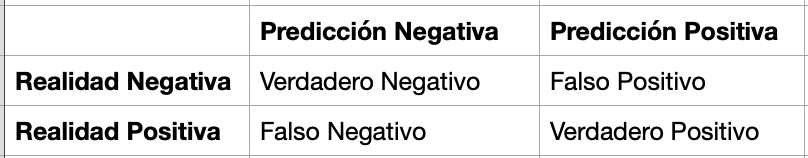

### Conclusion

En unas pocas líneas de código hemos sido capaces de construir una red neuronal recurrente con unos resultados muy buenos. Os animo a probar ca crear más capas convolucionales y de pooling o jugar con los parámetros para ver si lográis obtener resultados incluso mejores.